<a name="lib"></a>

# Import libraries and packages

In [1]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,Bidirectional
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


# Import Dataset

In [2]:
from google.colab import files
data_to_load = files.upload()

Saving samsung.csv to samsung.csv


In [3]:
maindf = pd.read_csv('samsung.csv')
maindf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,39400.0,39400.0,38550.0,38750.0,34697.902344,7847664
1,2019-01-03,38300.0,38550.0,37450.0,37600.0,33668.156250,12471493
2,2019-01-04,37450.0,37600.0,36850.0,37450.0,33533.843750,14108958
3,2019-01-07,38000.0,38900.0,37800.0,38750.0,34697.902344,12748997
4,2019-01-08,38000.0,39200.0,37950.0,38100.0,34115.867188,12756554


In [4]:
maindf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,955.000000,955.000000,955.000000,955.000000,955.000000,9.550000e+02
mean,61807.015707,62371.204188,61232.146597,61778.638743,58902.204663,1.651682e+07
std,13378.572937,13451.815871,13302.691130,13345.311806,14093.303008,8.665611e+06
min,37450.000000,37600.000000,36850.000000,37450.000000,33533.843750,0.000000e+00
25%,50000.000000,50400.000000,49625.000000,49950.000000,46172.000000,1.115114e+07
50%,59400.000000,59900.000000,58800.000000,59400.000000,56661.828125,1.482070e+07
75%,73900.000000,74350.000000,73150.000000,73850.000000,72018.976562,1.968547e+07
max,90300.000000,96800.000000,89500.000000,91000.000000,87764.804688,9.030618e+07


In [5]:
print("Total number of rowss/days: ",maindf.shape[0])
print("Total number of columns: ",maindf.shape[1])

Total number of rowss/days:  955
Total number of columns:  7


<a name="na"></a>

# Checking Null and NA value

In [6]:
print("Null values:", maindf.isnull().values.sum())
print("NA values:", maindf.isna().values.any())

Null values: 0
NA values: False


<a name="predate"></a>

# Convert Date field into datetime format

In [7]:
# convert date field from string to Date format 
maindf['Date'] = pd.to_datetime(maindf.Date)
maindf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,39400.0,39400.0,38550.0,38750.0,34697.902344,7847664
1,2019-01-03,38300.0,38550.0,37450.0,37600.0,33668.156250,12471493
2,2019-01-04,37450.0,37600.0,36850.0,37450.0,33533.843750,14108958
3,2019-01-07,38000.0,38900.0,37800.0,38750.0,34697.902344,12748997
4,2019-01-08,38000.0,39200.0,37950.0,38100.0,34115.867188,12756554


<a name="dur"></a>

### Find the duration of dataset

In [8]:
print("Starting date: ",maindf.iloc[0][0])
print("Ending date: ", maindf.iloc[-1][0])
print("Duration: ", maindf.iloc[-1][0]-maindf.iloc[0][0])

Starting date:  2019-01-02 00:00:00
Ending date:  2022-11-16 00:00:00
Duration:  1414 days 00:00:00


<a name="trend"></a>

### Trend comparision between stock open price, close price, high price, low price

In [9]:
names = cycle(['Stock Open Price','Stock Close Price','Stock High Price','Stock Low Price'])

fig = px.line(maindf, x=maindf.Date, y=[maindf['Open'], maindf['Close'], 
                                          maindf['High'], maindf['Low']],
             labels={'Date': 'Date','Value':'Stock value'})
fig.update_layout(title_text='Stock analysis chart', font_size=15, font_color='black',legend_title_text='Stock Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

fig.show()

<a name="df"></a>

### Take Close price as dataframe for Training and Predicting

In [10]:
closedf = maindf[['Date','Close']]
close_stock = closedf.copy()
print("Shape of Close dataframe:", closedf.shape)

Shape of Close dataframe: (955, 2)


<a name="pclose"></a>

### Plotting Stock Close price chart

In [11]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'Date':'Date','Close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8)
fig.update_layout(title_text='Stock Close price chart', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

<a name="norm"></a>

### Normalizing Close price

In [12]:
close_stock = closedf.copy()
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(955, 1)


<a name="split"></a>

### Prepare Data for train and test

In [13]:
training_size=int(len(closedf)*0.70)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (668, 1)
test_data:  (287, 1)


<a name="trans"></a>

### Make input shape before Data fed to the Model

In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (652, 15)
y_train:  (652,)
X_test:  (271, 15)
y_test (271,)


In [16]:
# reshape input to be [samples, time steps, features] which is required
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (652, 15, 1)
X_test:  (271, 15, 1)


<a name="gru"></a>

## Loop Optimizers and Models

In [165]:
# Optimizers
OptimizerList=["RMSprop","Adam","Adagrad","SGD"]
# Models
ModelList=["GRU","LSTM","Bi-LSTM"]


HistoryList=[]
predictionTrain=[]
predictionTest=[]


epochs=10
for oprimizer in OptimizerList:
  print(str(oprimizer))
  tempHistoryList=[]
  temppredictionTrain=[]
  temppredictionTest=[]
  #GRU
  tf.keras.backend.clear_session()
  model=Sequential()
  model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
  model.add(GRU(32,return_sequences=True))
  model.add(GRU(32))
  model.add(Dropout(0.20))
  model.add(Dense(1))
  model.compile(loss='MSE',optimizer=oprimizer)
  #LSTM
  tf.keras.backend.clear_session()
  model1=Sequential()
  model1.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
  model1.add(LSTM(32,return_sequences=True))
  model1.add(LSTM(32))
  model1.add(Dropout(0.20))
  model1.add(Dense(1))
  model1.compile(loss='MSE',optimizer=oprimizer)
  #Bi-LSTM
  tf.keras.backend.clear_session()
  model2=Sequential()
  model2.add(Bidirectional(LSTM(32,return_sequences=True,input_shape=(time_step,1))))
  model2.add(Bidirectional(LSTM(32,return_sequences=True)))
  model2.add(Bidirectional(LSTM(32)))
  model2.add(Dropout(0.20))
  model2.add(Dense(1))
  model2.compile(loss='MSE',optimizer=oprimizer)
  
  print(str(oprimizer)+"   -------------------------------    GRU")
  tempHistoryList.append(model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=15,verbose=1))
  print(str(oprimizer)+" predict  -------------------------------    GRU")
  temppredictionTrain.append(model.predict(X_train))
  temppredictionTest.append(model.predict(X_test)) 


  print(str(oprimizer)+"   -------------------------------    LSTM")
  tempHistoryList.append(model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=15,verbose=1))
  print(str(oprimizer)+" predict  -------------------------------    LSTM")
  temppredictionTrain.append(model1.predict(X_train))
  temppredictionTest.append(model1.predict(X_test)) 


  print(str(oprimizer)+"   -------------------------------    Bi-LSTM")
  tempHistoryList.append(model2.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=15,verbose=1))
  print(str(oprimizer)+" predict  -------------------------------    Bi-LSTM")
  temppredictionTrain.append(model2.predict(X_train))
  temppredictionTest.append(model2.predict(X_test)) 

  
  HistoryList.append(tempHistoryList)
  predictionTrain.append(temppredictionTrain)
  predictionTest.append(temppredictionTest)


RMSprop
RMSprop   -------------------------------    GRU
Epoch 1/10
44/44 [==============================] - 10s 56ms/step - loss: 0.0222 - val_loss: 0.0015
Epoch 2/10
44/44 [==============================] - 1s 25ms/step - loss: 0.0075 - val_loss: 0.0070
Epoch 3/10
44/44 [==============================] - 1s 26ms/step - loss: 0.0063 - val_loss: 0.0093
Epoch 4/10
44/44 [==============================] - 1s 27ms/step - loss: 0.0059 - val_loss: 0.0117
Epoch 5/10
44/44 [==============================] - 1s 26ms/step - loss: 0.0055 - val_loss: 7.2629e-04
Epoch 6/10
44/44 [==============================] - 1s 27ms/step - loss: 0.0047 - val_loss: 6.6007e-04
Epoch 7/10
44/44 [==============================] - 1s 27ms/step - loss: 0.0047 - val_loss: 7.5055e-04
Epoch 8/10
44/44 [==============================] - 1s 28ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 9/10
44/44 [==============================] - 1s 26ms/step - loss: 0.0040 - val_loss: 0.0012
Epoch 10/10
44/44 [====================

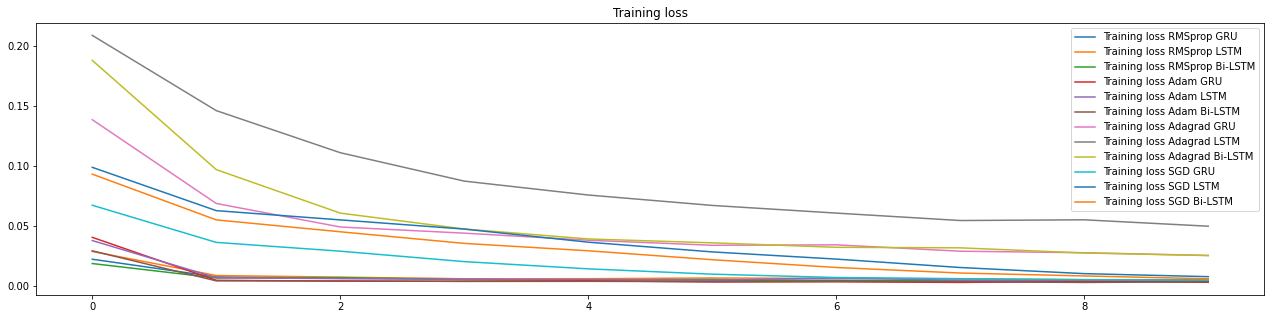

<Figure size 432x288 with 0 Axes>

In [168]:
import matplotlib.pyplot as plt

epochs = range(10)
plt.figure(figsize=(22,5))
for a in range(0,len(OptimizerList)):
  for b in range(0,len(ModelList)):
    plt.plot(epochs, HistoryList[a][b].history['loss'], label='Training loss '+str(OptimizerList[a])+' '+str(ModelList[b]))
    # plt.plot(epochs, HistoryList[a][b].history['val_loss'], label='Validation loss '+str(OptimizerList[a])+' '+str(ModelList[b]))

plt.title('Training loss')
plt.legend(loc=0)
plt.figure()


plt.show()

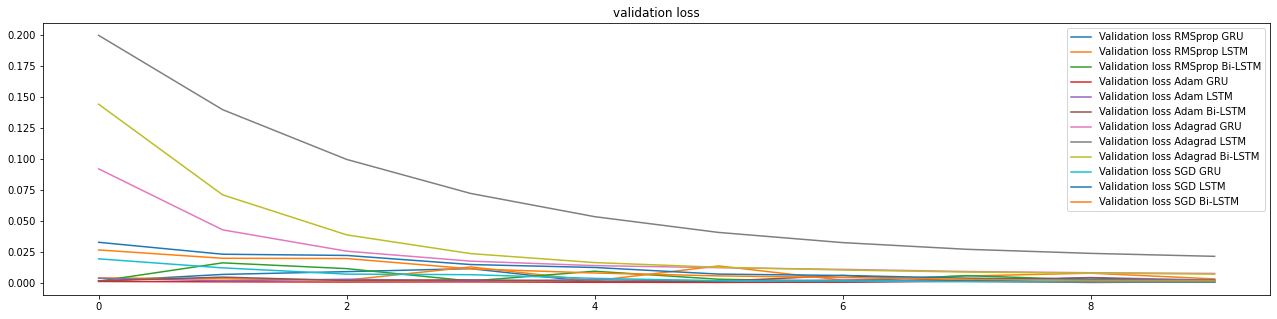

<Figure size 432x288 with 0 Axes>

In [169]:
import matplotlib.pyplot as plt

epochs = range(10)
plt.figure(figsize=(22,5))
for a in range(0,len(OptimizerList)):
  for b in range(0,len(ModelList)):
    # plt.plot(epochs, HistoryList[a][b].history['loss'], label='Training loss '+str(OptimizerList[a])+' '+str(ModelList[b]))
    plt.plot(epochs, HistoryList[a][b].history['val_loss'], label='Validation loss '+str(OptimizerList[a])+' '+str(ModelList[b]))

plt.title('validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

<a name="eval"></a>

# Model Evaluation

In [170]:
scaled_train_predictions=[]
scaled_test_predictions=[]
for a in range(0,len(OptimizerList)):
  tempscaled_train_predictions=[]
  tempscaled_test_predictions=[]
  for b in range(0,len(ModelList)):
    
    tempscaled_train_predictions.append(scaler.inverse_transform(predictionTrain[a][b]))
    tempscaled_test_predictions.append(scaler.inverse_transform(predictionTest[a][b]))
  scaled_train_predictions.append(tempscaled_train_predictions)
  scaled_test_predictions.append(tempscaled_test_predictions)


In [171]:
# Transform back to original form

original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

<a name="mse"></a>

### Evaluation metrices RMSE, MSE and MAE

Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [172]:

for a in range(0,len(OptimizerList)):
  for b in range(0,len(ModelList)):
  
    print("Train data "+str(OptimizerList[a])+' '+str(ModelList[b])+"_RMSE: ", math.sqrt(mean_squared_error(original_ytrain,scaled_train_predictions[a][b])))
    print("Train data "+str(OptimizerList[a])+' '+str(ModelList[b])+"_MSE: ", mean_squared_error(original_ytrain,scaled_train_predictions[a][b]))
    print("Train data "+str(OptimizerList[a])+' '+str(ModelList[b])+"_MAE: ", mean_absolute_error(original_ytrain,scaled_train_predictions[a][b]))
    print("                                                                                      ")
    print("Test data "+str(OptimizerList[a])+' '+str(ModelList[b])+"_RMSE: ", math.sqrt(mean_squared_error(original_ytest,scaled_test_predictions[a][b])))
    print("Test data "+str(OptimizerList[a])+' '+str(ModelList[b])+"_MSE: ", mean_squared_error(original_ytest,scaled_test_predictions[a][b]))
    print("Test data "+str(OptimizerList[a])+' '+str(ModelList[b])+"_MAE: ", mean_absolute_error(original_ytest,scaled_test_predictions[a][b]))
    
    print("-------------------------------------------------------------------------------------")

Train data RMSprop GRU_RMSE:  1625.1452156242735
Train data RMSprop GRU_MSE:  2641096.9718664666
Train data RMSprop GRU_MAE:  1285.191064752684
                                                                                      
Test data RMSprop GRU_RMSE:  1487.0084529192272
Test data RMSprop GRU_MSE:  2211194.1390532334
Test data RMSprop GRU_MAE:  1219.4624798201112
-------------------------------------------------------------------------------------
Train data RMSprop LSTM_RMSE:  3928.3716902651204
Train data RMSprop LSTM_MSE:  15432104.13687644
Train data RMSprop LSTM_MAE:  3205.146148868865
                                                                                      
Test data RMSprop LSTM_RMSE:  3129.7894529552723
Test data RMSprop LSTM_MSE:  9795582.019830063
Test data RMSprop LSTM_MAE:  2628.5293329105166
-------------------------------------------------------------------------------------
Train data RMSprop Bi-LSTM_RMSE:  3409.785856378999
Train data RMSprop Bi-LSTM

<a name="var"></a>

### Explained variance regression score


The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [173]:
for a in range(0,len(OptimizerList)):
  for b in range(0,len(ModelList)):
  
    print("Train data "+str(OptimizerList[a])+' '+str(ModelList[b])+" explained variance regression score: ", explained_variance_score(original_ytrain, scaled_train_predictions[a][b]))
    print("Test data "+str(OptimizerList[a])+' '+str(ModelList[b])+" explained variance regression score: ",explained_variance_score(original_ytest, scaled_test_predictions[a][b]))  
    print("-------------------------------------------------------------------------------------")

Train data RMSprop GRU explained variance regression score:  0.9874841251288463
Test data RMSprop GRU explained variance regression score:  0.9698137547527852
-------------------------------------------------------------------------------------
Train data RMSprop LSTM explained variance regression score:  0.9655717875334094
Test data RMSprop LSTM explained variance regression score:  0.9153910644143236
-------------------------------------------------------------------------------------
Train data RMSprop Bi-LSTM explained variance regression score:  0.9695081306435684
Test data RMSprop Bi-LSTM explained variance regression score:  0.9348262946121644
-------------------------------------------------------------------------------------
Train data Adam GRU explained variance regression score:  0.9898485332865055
Test data Adam GRU explained variance regression score:  0.9717476271859923
-------------------------------------------------------------------------------------
Train data Adam 

<a name="r2"></a>

### R<sup>2</sup> score for regression

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best <br>
0 or < 0 = worse

In [174]:
for a in range(0,len(OptimizerList)):
  for b in range(0,len(ModelList)):
  
    print("Train data "+str(OptimizerList[a])+' '+str(ModelList[b])+" R2 score: ", r2_score(original_ytrain, scaled_train_predictions[a][b]))
    print("Test data "+str(OptimizerList[a])+' '+str(ModelList[b])+" R2 score: ",r2_score(original_ytest, scaled_test_predictions[a][b]))  
    print("-------------------------------------------------------------------------------------")


Train data RMSprop GRU R2 score:  0.9874768559320529
Test data RMSprop GRU R2 score:  0.9584517961987702
-------------------------------------------------------------------------------------
Train data RMSprop LSTM R2 score:  0.9268264416504594
Test data RMSprop LSTM R2 score:  0.8159416077840083
-------------------------------------------------------------------------------------
Train data RMSprop Bi-LSTM R2 score:  0.9448706033450888
Test data RMSprop Bi-LSTM R2 score:  0.8542878954991506
-------------------------------------------------------------------------------------
Train data Adam GRU R2 score:  0.9874899705818029
Test data Adam GRU R2 score:  0.9459122036737515
-------------------------------------------------------------------------------------
Train data Adam LSTM R2 score:  0.9690541192035509
Test data Adam LSTM R2 score:  0.8683516290852547
-------------------------------------------------------------------------------------
Train data Adam Bi-LSTM R2 score:  0.97324841

<a name="mpd"></a>

### Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [176]:
for a in range(0,len(OptimizerList)):
  for b in range(0,len(ModelList)):
    # print("Train data MGD: "+str(OptimizerList[a])+' '+str(ModelList[b])+" MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
    # print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
    # print("----------------------------------------------------------------------")
    # print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
    # print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))
  
    print("Train data "+str(OptimizerList[a])+' '+str(ModelList[b])+" MGD: ", mean_gamma_deviance(original_ytrain, scaled_train_predictions[a][b]))
    print("Train data "+str(OptimizerList[a])+' '+str(ModelList[b])+" MPD: ",mean_poisson_deviance(original_ytest, scaled_test_predictions[a][b]))  
    print("-------------------------------------------------------------------------------------")



Train data RMSprop GRU MGD:  0.0008030248090867851
Train data RMSprop GRU MPD:  32.787388206478
-------------------------------------------------------------------------------------
Train data RMSprop LSTM MGD:  0.0039500458327566944
Train data RMSprop LSTM MPD:  148.68699844724105
-------------------------------------------------------------------------------------
Train data RMSprop Bi-LSTM MGD:  0.002661538301635032
Train data RMSprop Bi-LSTM MPD:  115.00460553120526
-------------------------------------------------------------------------------------
Train data Adam GRU MGD:  0.0007703969698768149
Train data Adam GRU MPD:  43.26687868725732
-------------------------------------------------------------------------------------
Train data Adam LSTM MGD:  0.0018209715195895504
Train data Adam LSTM MPD:  104.60072186615773
-------------------------------------------------------------------------------------
Train data Adam Bi-LSTM MGD:  0.0014279866794805114
Train data Adam Bi-LSTM MPD:

<a name="cp"></a>

# Comparision of original stock close price and predicted close prices

In [123]:
import pandas as pd

look_back=time_step
trends=[]
trends1=[]
for a in range(0,len(OptimizerList)):
  temps=[]
  for b in range(0,len(ModelList)):
    temp_trainPredictPlot = np.empty_like(closedf)
    temp_trainPredictPlot[:, :] = np.nan
    temp_trainPredictPlot[look_back:len(scaled_train_predictions[a][b])+look_back, :] = scaled_train_predictions[a][b]    
    temps.append(temp_trainPredictPlot)    
  trends.append(temps)




In [152]:
plotdf = pd.DataFrame({
                       'original_close': close_stock['Close'][:training_size]
                      
                      })
nameslist=[]
nameslist.append('original_close')

for a in range(0,len(OptimizerList)):
  for b in range(0,len(ModelList)):
    tempdf = pd.DataFrame({str(OptimizerList[a])+'_'+str(ModelList[b]): trends[a][b].reshape(1,-1)[0].tolist()})
    plotdf = pd.concat([plotdf, tempdf])
    nameslist.append(str(OptimizerList[a])+'_'+str(ModelList[b]))


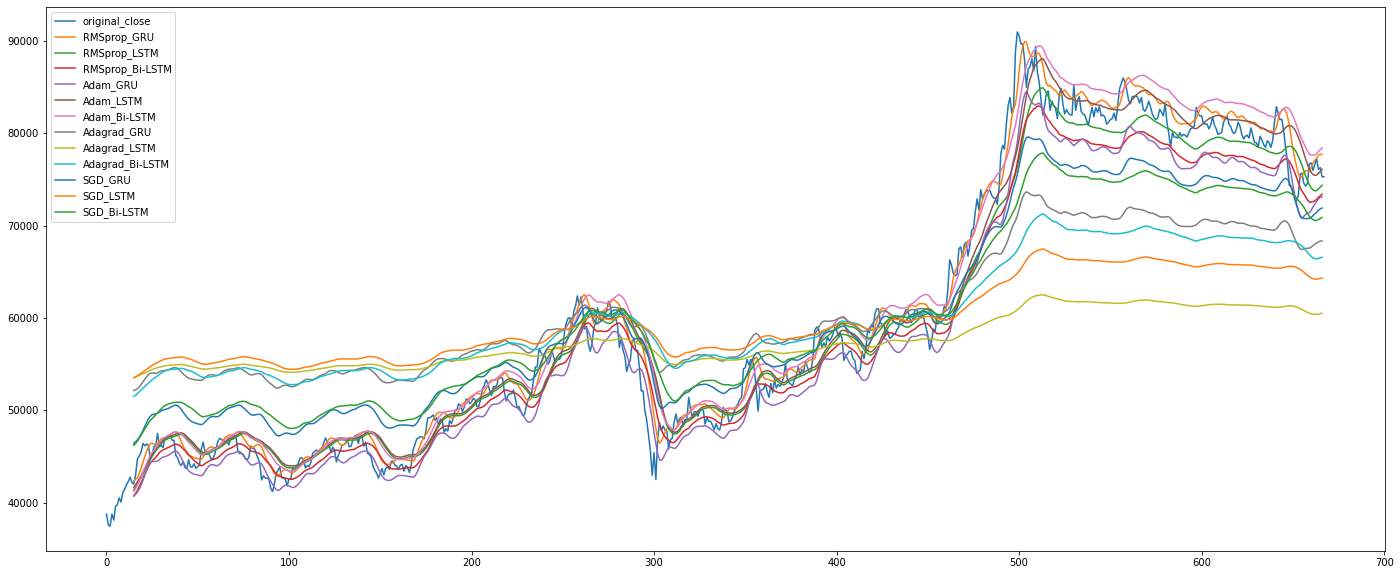

In [158]:
 plotdf.plot(figsize=(24, 10)); plt.legend(loc='best')


<a name="days"></a>

# Predicting next 30 days

In [160]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model2.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model2.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


<a name="pdays"></a>

### Plotting last 15 days of dataset and next predicted 30 days

In [161]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [162]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

# Reduce Time stem and experiment
 >Time Step set to 5


In [177]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (652, 15)
y_train:  (652,)
X_test:  (271, 15)
y_test (271,)


In [178]:
# reshape input to be [samples, time steps, features] which is required
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (652, 15, 1)
X_test:  (271, 15, 1)


<a name="gru"></a>

## Loop Optimizers and Models

In [179]:
# Optimizers
OptimizerList=["RMSprop","Adam","Adagrad","SGD"]
# Models
ModelList=["GRU","LSTM","Bi-LSTM"]


HistoryList=[]
predictionTrain=[]
predictionTest=[]


epochs=10
for oprimizer in OptimizerList:
  print(str(oprimizer))
  tempHistoryList=[]
  temppredictionTrain=[]
  temppredictionTest=[]
  #GRU
  tf.keras.backend.clear_session()
  model=Sequential()
  model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
  model.add(GRU(32,return_sequences=True))
  model.add(GRU(32))
  model.add(Dropout(0.20))
  model.add(Dense(1))
  model.compile(loss='MSE',optimizer=oprimizer)
  #LSTM
  tf.keras.backend.clear_session()
  model1=Sequential()
  model1.add(LSTM(32,return_sequences=True,input_shape=(time_step,1)))
  model1.add(LSTM(32,return_sequences=True))
  model1.add(LSTM(32))
  model1.add(Dropout(0.20))
  model1.add(Dense(1))
  model1.compile(loss='MSE',optimizer=oprimizer)
  #Bi-LSTM
  tf.keras.backend.clear_session()
  model2=Sequential()
  model2.add(Bidirectional(LSTM(32,return_sequences=True,input_shape=(time_step,1))))
  model2.add(Bidirectional(LSTM(32,return_sequences=True)))
  model2.add(Bidirectional(LSTM(32)))
  model2.add(Dropout(0.20))
  model2.add(Dense(1))
  model2.compile(loss='MSE',optimizer=oprimizer)
  print(str(oprimizer)+"   -------------------------------    GRU")
  tempHistoryList.append(model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=15,verbose=1))
  print(str(oprimizer)+" predict  -------------------------------    GRU")
  temppredictionTrain.append(model.predict(X_train))
  temppredictionTest.append(model.predict(X_test)) 
  print(str(oprimizer)+"   -------------------------------    LSTM")
  tempHistoryList.append(model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=15,verbose=1))
  print(str(oprimizer)+" predict  -------------------------------    LSTM")
  temppredictionTrain.append(model1.predict(X_train))
  temppredictionTest.append(model1.predict(X_test)) 
  print(str(oprimizer)+"   -------------------------------    Bi-LSTM")
  tempHistoryList.append(model2.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epochs,batch_size=15,verbose=1))
  print(str(oprimizer)+" predict  -------------------------------    Bi-LSTM")
  temppredictionTrain.append(model2.predict(X_train))
  temppredictionTest.append(model2.predict(X_test)) 
  HistoryList.append(tempHistoryList)
  predictionTrain.append(temppredictionTrain)
  predictionTest.append(temppredictionTest)


RMSprop
RMSprop   -------------------------------    GRU
Epoch 1/10
44/44 [==============================] - 11s 68ms/step - loss: 0.0196 - val_loss: 0.0025
Epoch 2/10
44/44 [==============================] - 1s 32ms/step - loss: 0.0072 - val_loss: 8.5967e-04
Epoch 3/10
44/44 [==============================] - 1s 30ms/step - loss: 0.0056 - val_loss: 0.0076
Epoch 4/10
44/44 [==============================] - 1s 30ms/step - loss: 0.0048 - val_loss: 0.0083
Epoch 5/10
44/44 [==============================] - 1s 32ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 6/10
44/44 [==============================] - 1s 31ms/step - loss: 0.0040 - val_loss: 0.0017
Epoch 7/10
44/44 [==============================] - 1s 31ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 8/10
44/44 [==============================] - 1s 30ms/step - loss: 0.0039 - val_loss: 6.0514e-04
Epoch 9/10
44/44 [==============================] - 1s 31ms/step - loss: 0.0044 - val_loss: 4.8889e-04
Epoch 10/10
44/44 [====================

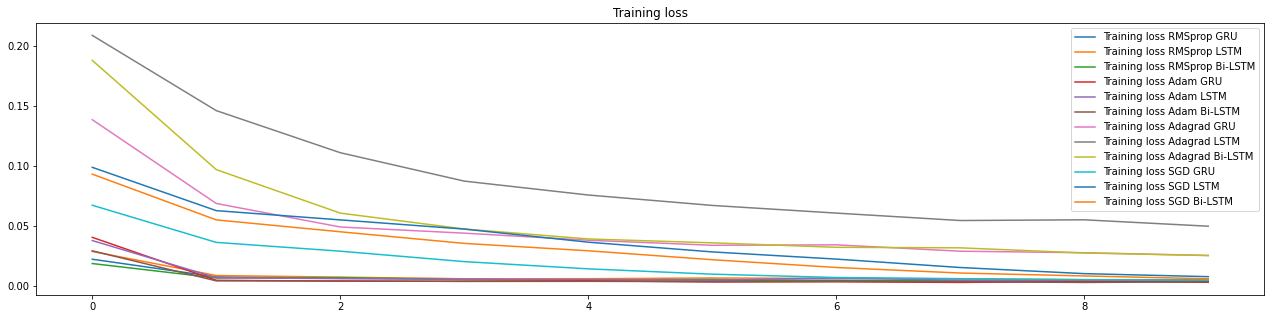

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

epochs = range(10)
plt.figure(figsize=(22,5))
for a in range(0,len(OptimizerList)):
  for b in range(0,len(ModelList)):
    plt.plot(epochs, HistoryList[a][b].history['loss'], label='Training loss '+str(OptimizerList[a])+' '+str(ModelList[b]))
    # plt.plot(epochs, HistoryList[a][b].history['val_loss'], label='Validation loss '+str(OptimizerList[a])+' '+str(ModelList[b]))

plt.title('Training loss')
plt.legend(loc=0)
plt.figure()


plt.show()

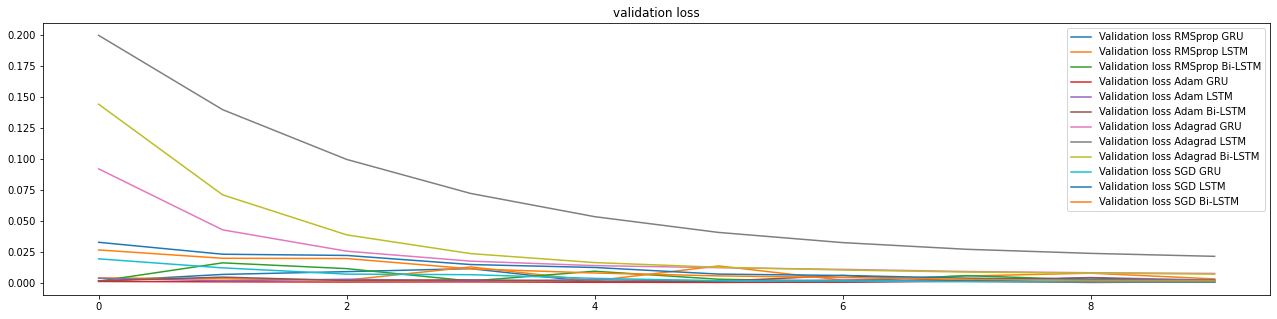

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

epochs = range(10)
plt.figure(figsize=(22,5))
for a in range(0,len(OptimizerList)):
  for b in range(0,len(ModelList)):
    # plt.plot(epochs, HistoryList[a][b].history['loss'], label='Training loss '+str(OptimizerList[a])+' '+str(ModelList[b]))
    plt.plot(epochs, HistoryList[a][b].history['val_loss'], label='Validation loss '+str(OptimizerList[a])+' '+str(ModelList[b]))

plt.title('validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

<a name="eval"></a>

# Model Evaluation

In [ ]:
scaled_train_predictions=[]
scaled_test_predictions=[]
for a in range(0,len(OptimizerList)):
  tempscaled_train_predictions=[]
  tempscaled_test_predictions=[]
  for b in range(0,len(ModelList)):
    
    tempscaled_train_predictions.append(scaler.inverse_transform(predictionTrain[a][b]))
    tempscaled_test_predictions.append(scaler.inverse_transform(predictionTest[a][b]))
  scaled_train_predictions.append(tempscaled_train_predictions)
  scaled_test_predictions.append(tempscaled_test_predictions)


In [ ]:
# Transform back to original form

original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

<a name="mse"></a>

### Evaluation metrices RMSE, MSE and MAE

Root Mean Square Error (RMSE), Mean Square Error (MSE) and Mean absolute Error (MAE) are a standard way to measure the error of a model in predicting quantitative data.

In [ ]:

for a in range(0,len(OptimizerList)):
  for b in range(0,len(ModelList)):
  
    print("Train data "+str(OptimizerList[a])+' '+str(ModelList[b])+"_RMSE: ", math.sqrt(mean_squared_error(original_ytrain,scaled_train_predictions[a][b])))
    print("Train data "+str(OptimizerList[a])+' '+str(ModelList[b])+"_MSE: ", mean_squared_error(original_ytrain,scaled_train_predictions[a][b]))
    print("Train data "+str(OptimizerList[a])+' '+str(ModelList[b])+"_MAE: ", mean_absolute_error(original_ytrain,scaled_train_predictions[a][b]))
    print("                                                                                      ")
    print("Test data "+str(OptimizerList[a])+' '+str(ModelList[b])+"_RMSE: ", math.sqrt(mean_squared_error(original_ytest,scaled_test_predictions[a][b])))
    print("Test data "+str(OptimizerList[a])+' '+str(ModelList[b])+"_MSE: ", mean_squared_error(original_ytest,scaled_test_predictions[a][b]))
    print("Test data "+str(OptimizerList[a])+' '+str(ModelList[b])+"_MAE: ", mean_absolute_error(original_ytest,scaled_test_predictions[a][b]))
    
    print("-------------------------------------------------------------------------------------")

Train data RMSprop GRU_RMSE:  1625.1452156242735
Train data RMSprop GRU_MSE:  2641096.9718664666
Train data RMSprop GRU_MAE:  1285.191064752684
                                                                                      
Test data RMSprop GRU_RMSE:  1487.0084529192272
Test data RMSprop GRU_MSE:  2211194.1390532334
Test data RMSprop GRU_MAE:  1219.4624798201112
-------------------------------------------------------------------------------------
Train data RMSprop LSTM_RMSE:  3928.3716902651204
Train data RMSprop LSTM_MSE:  15432104.13687644
Train data RMSprop LSTM_MAE:  3205.146148868865
                                                                                      
Test data RMSprop LSTM_RMSE:  3129.7894529552723
Test data RMSprop LSTM_MSE:  9795582.019830063
Test data RMSprop LSTM_MAE:  2628.5293329105166
-------------------------------------------------------------------------------------
Train data RMSprop Bi-LSTM_RMSE:  3409.785856378999
Train data RMSprop Bi-LSTM

<a name="var"></a>

### Explained variance regression score


The explained variance score explains the dispersion of errors of a given dataset, and the formula is written as follows: Here, and Var(y) is the variance of prediction errors and actual values respectively. Scores close to 1.0 are highly desired, indicating better squares of standard deviations of errors.

In [ ]:
for a in range(0,len(OptimizerList)):
  for b in range(0,len(ModelList)):
  
    print("Train data "+str(OptimizerList[a])+' '+str(ModelList[b])+" explained variance regression score: ", explained_variance_score(original_ytrain, scaled_train_predictions[a][b]))
    print("Test data "+str(OptimizerList[a])+' '+str(ModelList[b])+" explained variance regression score: ",explained_variance_score(original_ytest, scaled_test_predictions[a][b]))  
    print("-------------------------------------------------------------------------------------")

Train data RMSprop GRU explained variance regression score:  0.9874841251288463
Test data RMSprop GRU explained variance regression score:  0.9698137547527852
-------------------------------------------------------------------------------------
Train data RMSprop LSTM explained variance regression score:  0.9655717875334094
Test data RMSprop LSTM explained variance regression score:  0.9153910644143236
-------------------------------------------------------------------------------------
Train data RMSprop Bi-LSTM explained variance regression score:  0.9695081306435684
Test data RMSprop Bi-LSTM explained variance regression score:  0.9348262946121644
-------------------------------------------------------------------------------------
Train data Adam GRU explained variance regression score:  0.9898485332865055
Test data Adam GRU explained variance regression score:  0.9717476271859923
-------------------------------------------------------------------------------------
Train data Adam 

<a name="r2"></a>

### R<sup>2</sup> score for regression

R-squared (R2) is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model.

1 = Best <br>
0 or < 0 = worse

In [ ]:
for a in range(0,len(OptimizerList)):
  for b in range(0,len(ModelList)):
  
    print("Train data "+str(OptimizerList[a])+' '+str(ModelList[b])+" R2 score: ", r2_score(original_ytrain, scaled_train_predictions[a][b]))
    print("Test data "+str(OptimizerList[a])+' '+str(ModelList[b])+" R2 score: ",r2_score(original_ytest, scaled_test_predictions[a][b]))  
    print("-------------------------------------------------------------------------------------")


Train data RMSprop GRU R2 score:  0.9874768559320529
Test data RMSprop GRU R2 score:  0.9584517961987702
-------------------------------------------------------------------------------------
Train data RMSprop LSTM R2 score:  0.9268264416504594
Test data RMSprop LSTM R2 score:  0.8159416077840083
-------------------------------------------------------------------------------------
Train data RMSprop Bi-LSTM R2 score:  0.9448706033450888
Test data RMSprop Bi-LSTM R2 score:  0.8542878954991506
-------------------------------------------------------------------------------------
Train data Adam GRU R2 score:  0.9874899705818029
Test data Adam GRU R2 score:  0.9459122036737515
-------------------------------------------------------------------------------------
Train data Adam LSTM R2 score:  0.9690541192035509
Test data Adam LSTM R2 score:  0.8683516290852547
-------------------------------------------------------------------------------------
Train data Adam Bi-LSTM R2 score:  0.97324841

<a name="mpd"></a>

### Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [ ]:
for a in range(0,len(OptimizerList)):
  for b in range(0,len(ModelList)):
    # print("Train data MGD: "+str(OptimizerList[a])+' '+str(ModelList[b])+" MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
    # print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
    # print("----------------------------------------------------------------------")
    # print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
    # print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))
  
    print("Train data "+str(OptimizerList[a])+' '+str(ModelList[b])+" MGD: ", mean_gamma_deviance(original_ytrain, scaled_train_predictions[a][b]))
    print("Train data "+str(OptimizerList[a])+' '+str(ModelList[b])+" MPD: ",mean_poisson_deviance(original_ytest, scaled_test_predictions[a][b]))  
    print("-------------------------------------------------------------------------------------")



Train data RMSprop GRU MGD:  0.0008030248090867851
Train data RMSprop GRU MPD:  32.787388206478
-------------------------------------------------------------------------------------
Train data RMSprop LSTM MGD:  0.0039500458327566944
Train data RMSprop LSTM MPD:  148.68699844724105
-------------------------------------------------------------------------------------
Train data RMSprop Bi-LSTM MGD:  0.002661538301635032
Train data RMSprop Bi-LSTM MPD:  115.00460553120526
-------------------------------------------------------------------------------------
Train data Adam GRU MGD:  0.0007703969698768149
Train data Adam GRU MPD:  43.26687868725732
-------------------------------------------------------------------------------------
Train data Adam LSTM MGD:  0.0018209715195895504
Train data Adam LSTM MPD:  104.60072186615773
-------------------------------------------------------------------------------------
Train data Adam Bi-LSTM MGD:  0.0014279866794805114
Train data Adam Bi-LSTM MPD:

<a name="cp"></a>

# Comparision of original stock close price and predicted close prices

In [ ]:
import pandas as pd

look_back=time_step
trends=[]
trends1=[]
for a in range(0,len(OptimizerList)):
  temps=[]
  for b in range(0,len(ModelList)):
    temp_trainPredictPlot = np.empty_like(closedf)
    temp_trainPredictPlot[:, :] = np.nan
    temp_trainPredictPlot[look_back:len(scaled_train_predictions[a][b])+look_back, :] = scaled_train_predictions[a][b]    
    temps.append(temp_trainPredictPlot)    
  trends.append(temps)




In [ ]:
plotdf = pd.DataFrame({
    # 'date': close_stock['Date'],
                       'original_close': close_stock['Close'][:training_size]
                      
                      })
nameslist=[]
nameslist.append('original_close')

for a in range(0,len(OptimizerList)):
  for b in range(0,len(ModelList)):
    tempdf = pd.DataFrame({str(OptimizerList[a])+'_'+str(ModelList[b]): trends[a][b].reshape(1,-1)[0].tolist()})
    plotdf = pd.concat([plotdf, tempdf])
    nameslist.append(str(OptimizerList[a])+'_'+str(ModelList[b]))
    
# overall=[]
# overall.append(plotdf['original_close'])
# for a in range(0,len(OptimizerList)):
#   for b in range(0,len(ModelList)):
#     tempname=str(OptimizerList[a])+'_'+str(ModelList[b])
#     # print(trends[a][b])
#     overall.append(trends[a][b])

# names = cycle(nameslist)

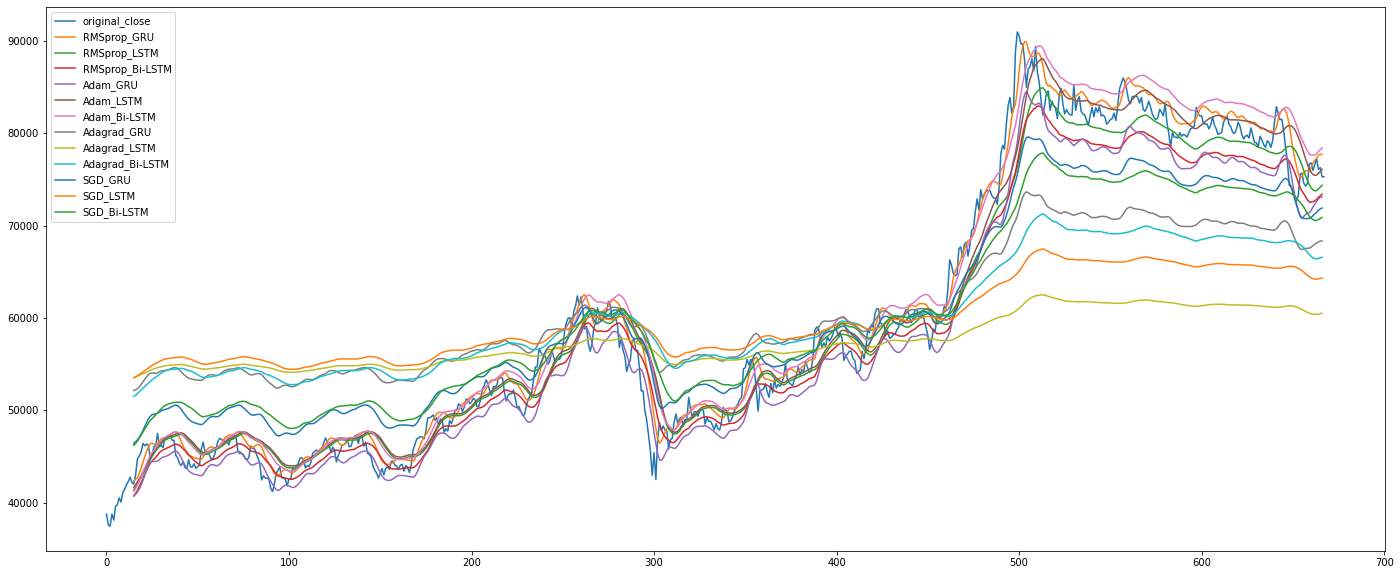

In [ ]:
 plotdf.plot(figsize=(24, 10)); plt.legend(loc='best')


Highest varience score obtain at Timesteps =5 with **Adam optimizer and GRU Model**





*   Train data **Adam GRU** explained variance regression score:  0.9898485332865055
*   Test data **Adam GRU** explained variance regression score:  0.9717476271859923



 
